# Stock Forecasting using pmdarima

https://github.com/alkaline-ml/pmdarima

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import ndiffs, nsdiffs
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error

import yfinance as yf
yf.pdr_override()

In [2]:
stock = 'AMD' # input
start = '2017-01-01' # input 
end = '2021-11-08'  # input
df = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,11.42,11.65,11.02,11.43,11.43,55182000
2017-01-04,11.45,11.52,11.24,11.43,11.43,40781200
2017-01-05,11.43,11.69,11.23,11.24,11.24,38855200
2017-01-06,11.29,11.49,11.11,11.32,11.32,34453500
2017-01-09,11.37,11.64,11.31,11.49,11.49,37304800


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,119.449997,125.669998,118.129997,125.230003,125.230003,54559800
2021-11-02,124.980003,128.460007,124.199997,127.629997,127.629997,53491900
2021-11-03,127.750000,130.600006,126.790001,130.529999,130.529999,59537800
2021-11-04,132.009995,139.000000,130.770004,137.500000,137.500000,84825200
2021-11-05,139.190002,141.220001,134.419998,136.339996,136.339996,64878000


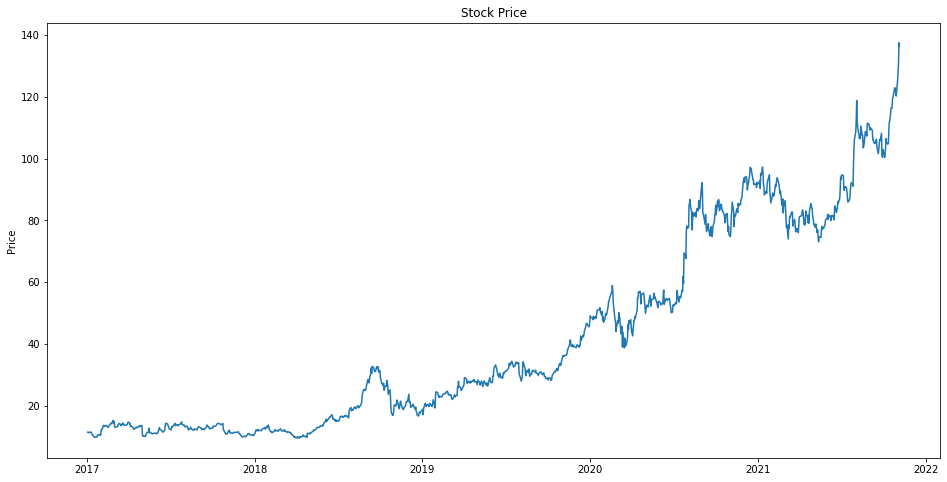

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.title('Stock Price')
plt.ylabel('Price')
plt.show()

In [6]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,11.42,11.65,11.02,11.43,11.43,55182000
1,2017-01-04,11.45,11.52,11.24,11.43,11.43,40781200
2,2017-01-05,11.43,11.69,11.23,11.24,11.24,38855200
3,2017-01-06,11.29,11.49,11.11,11.32,11.32,34453500
4,2017-01-09,11.37,11.64,11.31,11.49,11.49,37304800


In [7]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Open'].values
y_test = test_data['Open'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

976 train samples
245 test samples


In [8]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [9]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3314.582, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3313.554, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3310.744, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3310.717, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3314.413, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3312.651, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3312.707, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3313.222, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3312.040, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.329 seconds


In [10]:
print(auto.order)

(0, 1, 1)


In [11]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 4.8030548105380655
SMAPE: 1.7474407751064565


C:\Users\Tin Hang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  del sys.path[0]
C:\Users\Tin Hang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


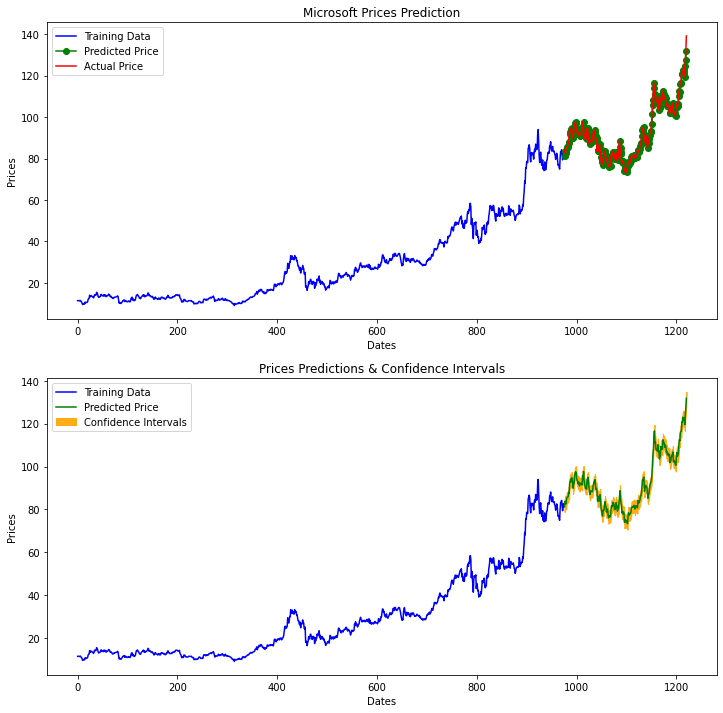

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 1500, 800).tolist(), df['Date'][0:1500:800].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 1500, 800).tolist(), df['Date'][0:1500:800].tolist())
axes[1].legend()

